In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [2]:
df1 = pd.read_csv('/home/jieun201/oct4_MCwithQuantInputs/InputTrainSet.csv')
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0.0,0.0,0.0,0.0,3.0,19.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,7.983680
1,0.0,0.0,0.0,0.0,8.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.281560
2,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.477150
3,0.0,0.0,0.0,0.0,7.0,20.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587562
4,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.779220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792771,0.0,0.0,0.0,0.0,2.0,6.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.330486
792772,0.0,0.0,0.0,9.0,20.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.250600
792773,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.483710
792774,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.619700


In [3]:
df2 = pd.read_csv('/home/jieun201/oct4_MCwithQuantInputs/labelsTrain.csv')
df2

,ptLabel
0,0
1,1
2,0
3,1
4,1
...,...
792771,2
792772,0
792773,2
792774,1


In [4]:
df3 = pd.read_csv('/home/jieun201/oct4_MCwithQuantInputs/InputTestSet.csv')
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0.0,0.0,4.0,5.0,5.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.906050
1,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.082580
2,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127132
3,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.684330
4,0.0,0.0,0.0,0.0,0.0,6.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,-2.855120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198191,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.484750
198192,0.0,0.0,0.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515319
198193,0.0,0.0,0.0,0.0,1.0,8.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,2.604940
198194,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.879390


In [5]:
df4 = pd.read_csv('/home/jieun201/oct4_MCwithQuantInputs/labelsTest.csv')
df4

,ptLabel
0,2
1,0
2,1
3,0
4,1
...,...
198191,1
198192,2
198193,2
198194,2


In [6]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(792776, 14) (198196, 14) (792776, 1) (198196, 1)


In [7]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [2],
       [1],
       [0]])

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [9]:
X_test

array([[-0.08375047, -0.15356308,  2.2621688 , ..., -0.06391906,
        -0.05634835, -1.30228773],
       [-0.08375047, -0.15356308, -0.37018805, ..., -0.06391906,
        -0.05634835,  1.79898265],
       [-0.08375047, -0.15356308, -0.37018805, ..., -0.06391906,
        -0.05634835,  0.03526489],
       ...,
       [-0.08375047, -0.15356308, -0.37018805, ..., -0.06391906,
        -0.05634835,  0.58459335],
       [-0.08375047, -0.15356308, -0.37018805, ..., -0.06391906,
        -0.05634835,  1.75393556],
       [-0.08375047, -0.15356308, -0.37018805, ..., -0.06391906,
        -0.05634835,  1.51074244]])

In [10]:
from tensorflow.keras.layers import Input, Activation
#from qkeras import quantized bits
#from qkeras import QDense, QActivation
from qkeras import *

def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDense(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = QActivation("quantized_relu(10,0)", name="relu-1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
    
    

model=CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()



2022-10-09 07:46:31.613550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 07:46:31.648213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 07:46:31.648523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 07:46:31.649818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 relu-1 (QActivation)        (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Activation)        (None, 3)                 0         
                                                             

In [11]:

es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/150


/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 60/620 [=>............................] - ETA: 1s - loss: 1.0456 - sparse_categorical_accuracy: 0.4667 

2022-10-09 07:46:35.339767: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


620/620 [==============================] - 3s 3ms/step - loss: 0.8497 - sparse_categorical_accuracy: 0.6011 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.6786
Epoch 2/150
620/620 [==============================] - 2s 3ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.7232
Epoch 3/150
620/620 [==============================] - 2s 3ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.7264 - val_loss: 0.6088 - val_sparse_categorical_accuracy: 0.7316
Epoch 4/150
620/620 [==============================] - 2s 3ms/step - loss: 0.6081 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.5966 - val_sparse_categorical_accuracy: 0.7389
Epoch 5/150
620/620 [==============================] - 2s 3ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.5892 - val_sparse_categorical_accuracy: 0.7415
Epoch 6/150
620/620 [==============================] - 2s 3ms/step - loss: 0.5954 - sparse_categorical_accu

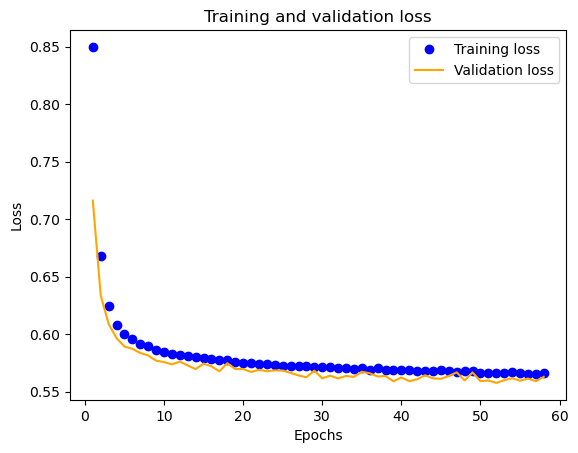

In [12]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

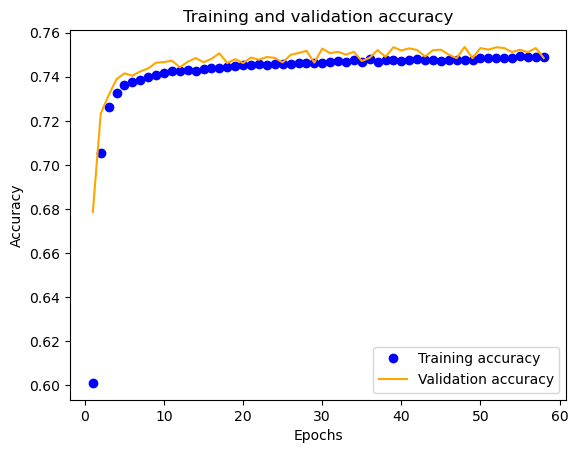

In [13]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [14]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

In [15]:
predictionsFiles

array([2, 0, 0, ..., 2, 0, 2])

In [16]:
pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [17]:
pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5532140731811523
Test accuracy: 0.7561555504798889


Confusion matrix:
[[81163  8617  9318]
 [15343 33843   363]
 [14563   125 34861]]


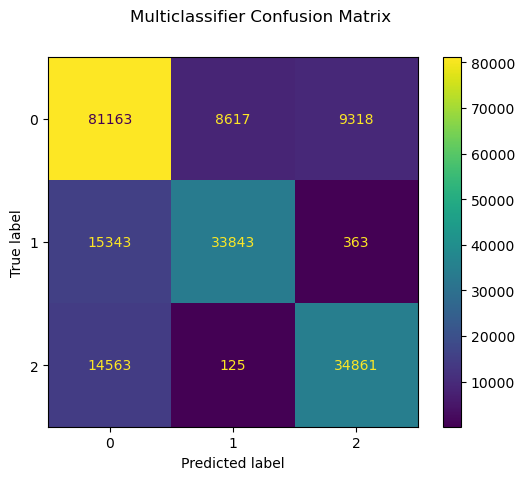

In [19]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()